In [ ]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [1]:
import torch
from avicortex.datasets import CandiShareSchizophreniaDataset
from torch_geometric.loader import DataLoader

In [2]:
tr_dataset = CandiShareSchizophreniaDataset(
    "left",
    freesurfer_out_path="../datasets/candishare_schizophrenia_dktatlas.csv",
    mode="train",
    in_view_idx=0,
    out_view_idx=2,
)
tr_dataloader = DataLoader(tr_dataset, batch_size=5)
g_source, g_target = next(iter(tr_dataloader))

Hem:lh, Edges found: (34, 34, 94, 5)
Hem:lh, Nodes found: (34, 94, 5)


In [3]:
from model import SinusoidalPositionEmbeddings

TIMESTEP = 5
net = SinusoidalPositionEmbeddings(6)
input_time = torch.ones(1).to("cuda") * TIMESTEP
print(input_time)
learned_embed = net(input_time)
learned_embed

tensor([5.], device='cuda:0')


tensor([[-9.5892e-01,  4.9979e-02,  5.0000e-04,  2.8366e-01,  9.9875e-01,
          1.0000e+00]], device='cuda:0')

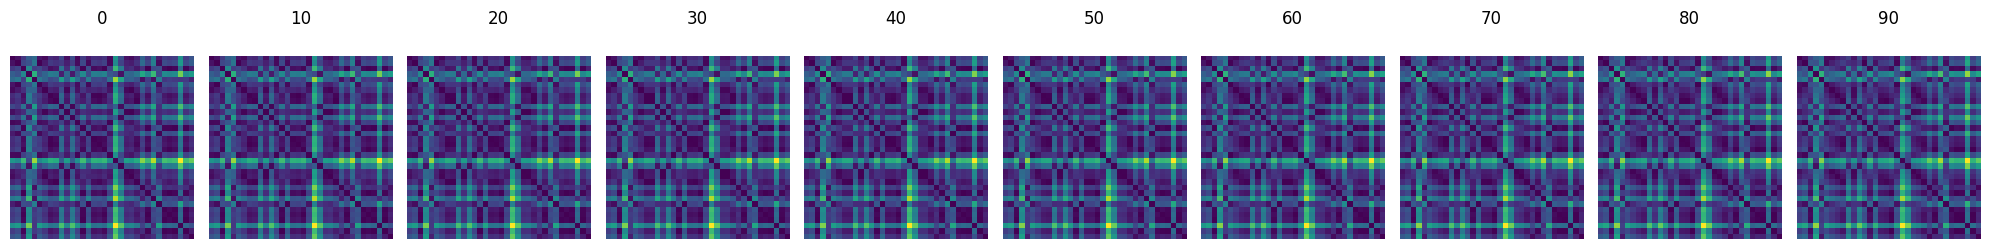

In [6]:
from diffusion import GraphDiffusion
from model import GrenolNet
from plotting import plot_graph_adjacency

diffuser = GraphDiffusion(
    step_count=100,
    noise_schedule="linear",
    noise_dist="normal",
    noise_mean=0.0,
    noise_std=0.01,
    noise_max=0.02,
)

model = GrenolNet(1, 1, 34, 48).to(device="cuda")
model.load_state_dict(
    torch.load(
        "../models/cs_left_500epochs_5folds_batchnorm/cs_left_500epochs_5folds_batchnorm_fold0.pth"
    )
)

TIMESTEP = 99
noisy_graphs, added_noise = diffuser.forward_add_noise_to_batch(g_target)
plot_graph_adjacency(noisy_graphs[::10], list(range(0, 100, 10)), figsize=20)
timesteps = torch.randint(
    0, diffuser.step_count, (g_target.x.shape[0],), device="cuda"
).long()
pred_noise = model.forward(noisy_graphs[TIMESTEP], g_source, timesteps)

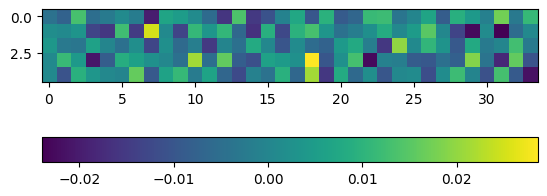

In [7]:
import matplotlib.pyplot as plt

plt.imshow(added_noise.cpu().detach().numpy())
plt.colorbar(orientation="horizontal")
plt.show()

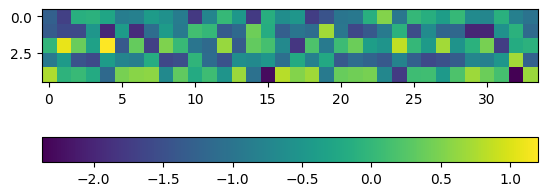

In [9]:
TIMESTEP = 99
pred_noise = model.forward(noisy_graphs[TIMESTEP], g_source, timesteps)
plt.imshow(pred_noise.squeeze().cpu().detach().numpy())
plt.colorbar(orientation="horizontal")
plt.show()

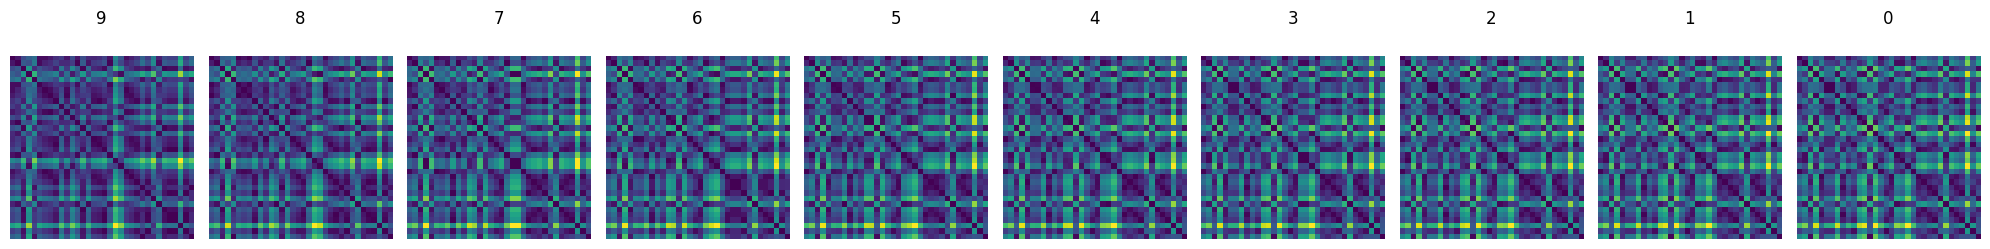

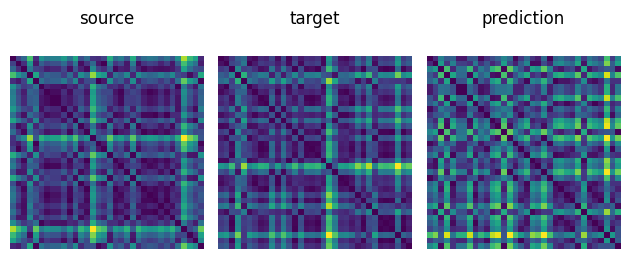

Frobenius loss between target and prediction: 7.669689655303955


In [11]:
from plotting import plot_graph_adjacency
from torch_geometric.data import Data as PygData

g_source_sample = g_source.to_data_list()[0]
noise = diffuser.create_noise_like(g_source_sample.x)
noisy_edge_attr = diffuser.calculate_edges(noise.squeeze(0))
edge_index = diffuser.create_edge_connectivity(len(noise.squeeze()))
full_noise_graph = PygData(
    x=noise,
    edge_index=edge_index,
    edge_attr=noisy_edge_attr.unsqueeze(0),
)
# noisy_graphs, applied_noise = test_diffuser.forward_add_noise(gaussian1)
# denoised_graphs = diffuser.forward_remove_noise(
#     model,
#     full_noise_graph,
#     source_graph=g_source_sample,
#     noise=noise,
# )
SAMPLE_IDX_IN_BATCH = 0
denoised_graphs = diffuser.forward_remove_noise(
    added_noise[0:1], noisy_graphs[-1].to_data_list()[0], noise=added_noise[0:1]
)
# denoised_graphs = diffuser.forward_remove_noise(
#     added_noise,
#     denoised_graphs[-1],
#     noise=added_noise
# )
plot_graph_adjacency(denoised_graphs[::10], list(range(10))[::-1], figsize=20)
plot_graph_adjacency(
    [g_source_sample, g_target, denoised_graphs[-1]], ["source", "target", "prediction"]
)
frob = torch.sqrt(
    torch.square(denoised_graphs[-1].edge_attr - g_target.edge_attr).sum()
).mean()
print("Frobenius loss between target and prediction:", frob.item())